# Word Vectors: 

**Thanks to Dr. Christopher Manning for the great content on NLP.**

We explore two types of word vectors in this notebook; those derived from *occurance matrices* and those from *word2vec*. Word vectors involve embedding the meaning of a word in a lower dimension in the form of a vector, hence the terms *word vectors* and *word embeddings* can be used interchangably. 

In the words of John Rupert Firth the idea in NLP is often, **"You shall know a word by the company it keeps"**. 

## Count based word vectors: 

**Intuition on Word Vectors and Count based methods:** Many words that are (near) synonyms are used in a similar context. That is, similar words are used along with a shared subset of words (or contexts). We will examine these contexts to develop the word embeddings. (Old school) Word vectors are often constructed using word count methods. One such strategy is the *co-occurance matrix*. 

### Co-Occurrence: 
Co-occurance measures how often a words co-occurs with one another. For example, give a word $w_{j}$, we consider the context window for length $n$, that is words: [$w_{j-n}$, $w_{j-(n-1)}$, $ .. $, $w_{j+n-1}$, $w_{j+n}$]. We get a symmetric matrix, which is usually large and requires dimention reduction using PCA or other dimentionality reduction techniques. 


In [5]:
#reading articles in Reuter's crude (petroleum related) articles

def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [7]:
# Printing it out. 
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

Determing the number of distinct words and number of distinct words in the corpus. 

In [221]:
def distinct_words(corpus= reuters_corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted.
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    corpus_words += [x for y in corpus for x in y  ]
    corpus_words = sorted(list(set(corpus_words)))
    num_corpus_words = len(corpus_words)

    return corpus_words, num_corpus_words

Running a sanity check:

In [222]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
test_corpus_words, num_corpus_words = distinct_words(corpus = test_corpus)

# Correct answers
ans_test_corpus_words = sorted(list(set(["START", "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", "END"])))
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [239]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "START All that glitters is not gold END" with window size of 4,
              "All" will co-occur with "START", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    raw_words = [x for y in corpus for x in y]
    
    words, num_words = distinct_words(corpus)
    M = np.zeros((num_words, num_words) )
    
    word2Ind = {}
    
    word2Ind = {words[i] : i for i in range(len(words))}
    
    for i in range(len(raw_words)):
        for j in range(max( (i-window_size), 0), min((i + window_size+1), len(raw_words))):
            if i != j  :
                #Dont want to add sentence "START END or END START"
                #if not ( ( word2Ind[raw_words[i]] ==word2Ind["START"] and  word2Ind[raw_words[j]]==word2Ind["END"]) or ( word2Ind[raw_words[i]] ==word2Ind["END"] and  word2Ind[raw_words[j]]==word2Ind["START"])) :
                    M[ word2Ind[raw_words[i]], word2Ind[raw_words[j]] ] += 1

    return M, word2Ind


In [240]:
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
[corpus, size_corpus] = distinct_words(corpus= test_corpus)
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2Ind
M_test_ans = np.array( 
    [[0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,],
     [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,],
     [0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,]]
)
word2Ind_ans = {'All': 0, "All's": 1, 'END': 2, 'START': 3, 'ends': 4, 'glitters': 5, 'gold': 6, "isn't": 7, 'that': 8, 'well': 9}

# Test correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Correct M:
[[0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0. 0. 0. 1. 0.]]
Your M: 
[[0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0. 0. 0. 1. 0.]]


AssertionError: Incorrect count at index (2, 3)=(END, START) in matrix M. Yours has 1.0 but should have 0.0.

## PCA to reduce co-occurancy matrix to k dims: 

In [241]:
from sklearn.decomposition import TruncatedSVD
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    svd = TruncatedSVD(n_components=k, n_iter=7, random_state=42)
    svd.fit(M)
    M_reduced = svd.transform(M)
    print("Done.")
    return M_reduced

In [232]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [322]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """    
    # simulating a pandas df['type'] column
    plt.figure(figsize = (30,20))
    types = words
    x_coords = [M_reduced[word2Ind[words[i] ], 0] for i in range(len(words))]
    y_coords = [M_reduced[word2Ind[words[i] ], 1] for i in range(len(words))]

    for i,type in enumerate(types):
        x = x_coords[i]
        y = y_coords[i]
        plt.scatter(x, y, marker='x', color='red')
        if i%2 ==0:
            mul = 1
        else: 
            mul = -1
        plt.text(x+0.00027, y + mul*0.00097, type, fontsize=12)
    plt.show()

Running Truncated SVD over 8185 words...
Done.


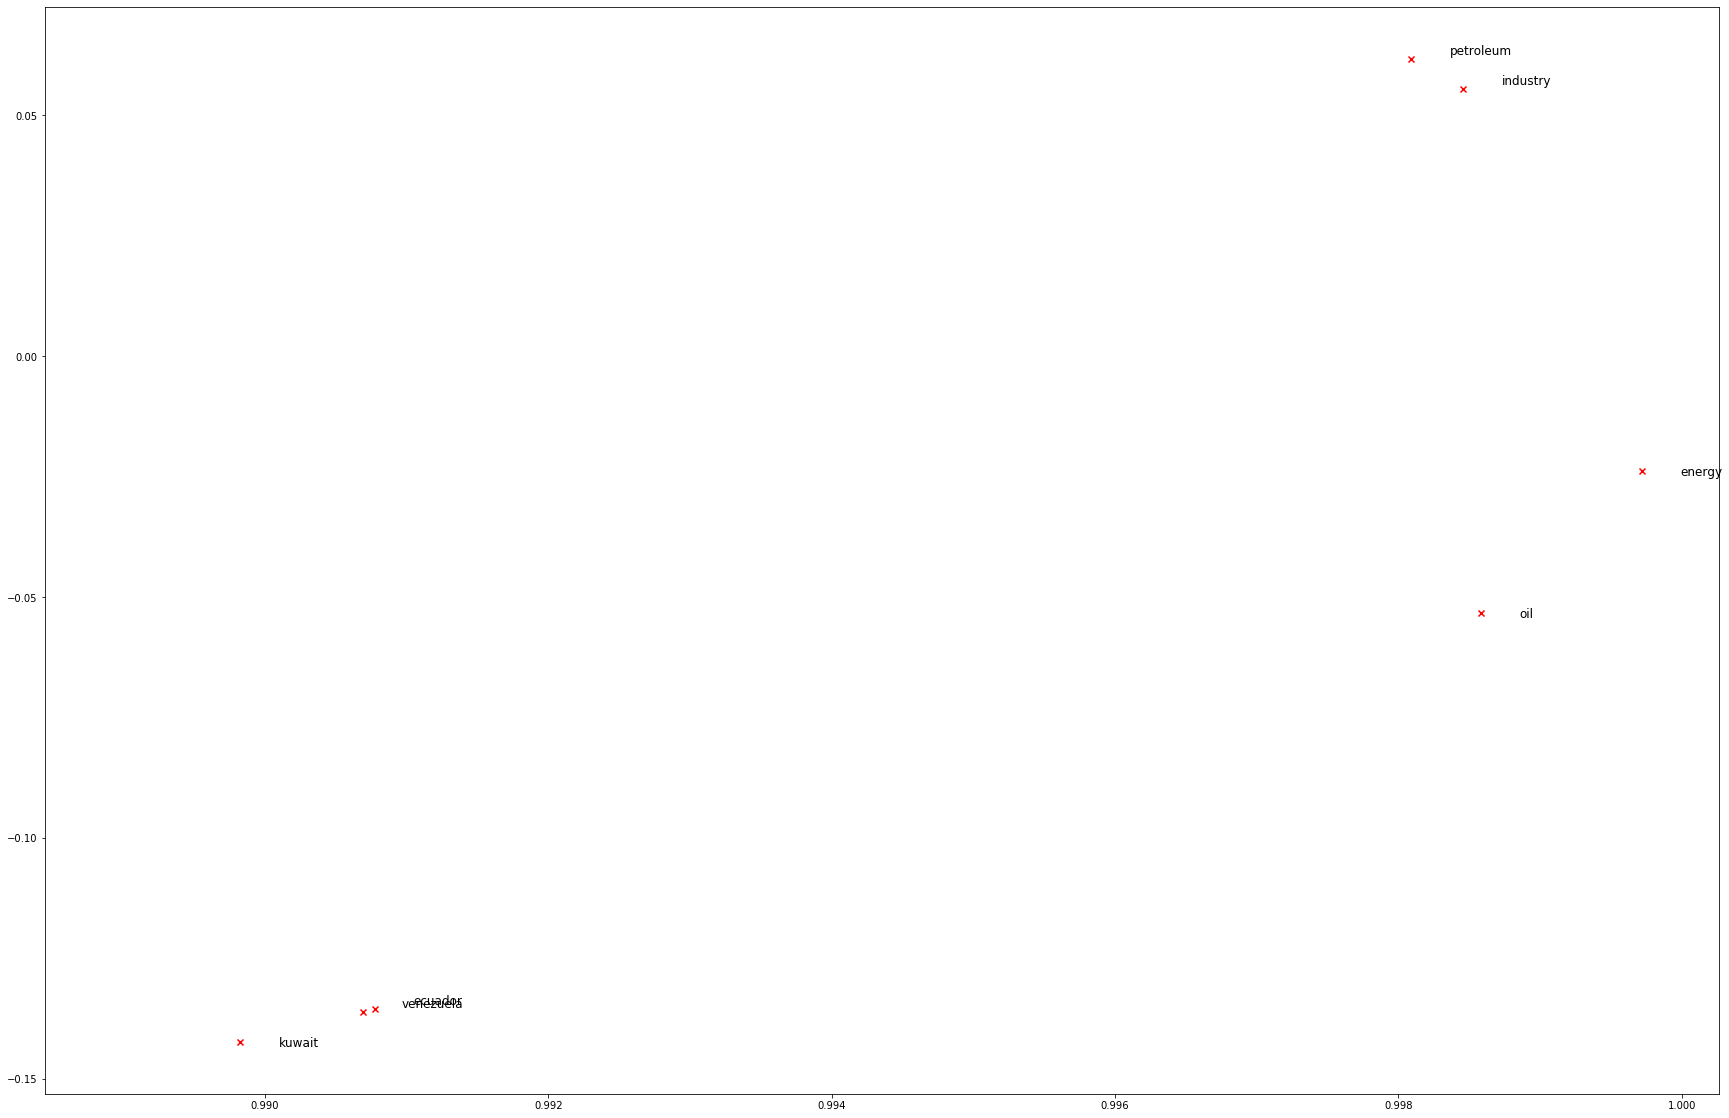

In [323]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
%matplotlib inline
import matplotlib.pyplot as plt

reuters_corpus = read_corpus()
[M_co_occurrence, word2Ind_co_occurrence] = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

#words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
words = ['ecuador', 'energy', 'industry', 'kuwait', 'venezuela', 'oil', 'petroleum' ]
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

## Part 2: Prediction-Based Word Vectors

This part explores the use of word2vec algorithm to create word embeddings. 

Let us first create a function to read the information.The function takes several minutes to run. 

In [2]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    vocab = list(wv_from_bin.vocab.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [324]:
"""
Loading word-vectors: Takes a few minutes, uncomment for selective run. 
"""

wv_from_bin = load_word2vec()

Loaded vocab size 3000000


In [328]:
type(wv_from_bin)

TypeError: 'str' object is not callable

#### Reducing dimensionality of Word2Vec Word Embeddings

In [329]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 3 million word2vec vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [330]:
# -----------------------------------------------------------------
# Run Cell to Reduce 300-Dimensinal Word Embeddings to k Dimensions
# Note: This may take several minutes
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.
